# Generating the analysis-ready BGC-Argo dataset
### Haruto Fujishima, Hakase Hayashida (Application Laboratory, JAMSTEC)

##### Biogeochemical Argo (BGC-Argo) is a global array of autonomous profiling floats that monitor marine ecosystem health in the upper 2,000 meters of the water column on a weekly basis. Here we develop such a post-processing tool that generates “analysis-ready” time series of biogeochemical profiles from a selected float. This tool is written in Python and uses Jupyter Notebook. Users can produce, visualize, and analyze the time series of their interest based on the time, geographic region, and biogeochemical variables.

### Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc4
import statistics
from datetime import datetime, timedelta, timezone
from scipy.ndimage import generic_filter
import matplotlib.dates as mdates
import multiprocessing
from scipy import interpolate
from pylab import rcParams
from matplotlib.colors import Normalize
from netCDF4 import Dataset
import glob
import gsw
import pvlib
from pvlib.location import Location
plt.rcParams['font.family'] = 'Times New Roman'

### Preparation for data download

In [3]:
data = pd.read_csv('https://usgodae.org/ftp/outgoing/argo/argo_synthetic-profile_index.txt',skiprows=8)

### Define spatial and temporal coverages

In [5]:
lon0 = 130
lon1 = 150
lat0 = 20
lat1 = 50
date0 = 20240101
date1 = 20241231

In [6]:
#extract the dataset based on lon, lat, and variable (chl). Date has a weird format so extract first then postprocess dates
datasub = data[(data['longitude'] >= lon0) & (data['longitude'] <= lon1) & (data['latitude'] >= lat0) &
               (data['latitude'] <= lat1) & (data['date'] >= 0) & (data['parameters'].str.contains(' CHLA '))]

#add the new variable called 'hour' referring to the hour of sampling
#extract the two digits after yyyymmdd corresponding to hh of hhmmss
hourstr = [str(num) for num in datasub['date']]
hourstr = [num[8:8+2] for num in hourstr]
hourint = [int(num) for num in hourstr]
datasub['hour'] = hourint

#add the new variable called 'time' referring to the hour of sampling
#extract the 6 digits after yyyymmdd corresponding to hhmmss
#NOTE: time is provided as string to avoid inconsistent digits for hours
timestr = [str(num) for num in datasub['date']]
timestr = [num[8:8+6] for num in timestr]
datasub['time'] = timestr

#modify the date format to be yyyymmdd
datestr = [str(num) for num in datasub['date']]
datestr = [num[0:8] for num in datestr]
dateint = [int(num) for num in datestr]
datasub['date'] = dateint
#create a new column called floatid for lagrangian time series plot
tmpfloatid = []
for i in range(np.size(datasub['date'])):
    tmpfloatid.append(datasub['file'].values[i].split('/')[1])
datasub['floatid'] = tmpfloatid
#refine the dataset based on the selected period
datasub = datasub[(datasub['date'].values >= date0) & (datasub['date'].values <= date1)]

/var/folders/1j/tpsfn7p15fn9p_jppny0yq8w0000gp/T/ipykernel_3884/3062507666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub['hour'] = hourint
/var/folders/1j/tpsfn7p15fn9p_jppny0yq8w0000gp/T/ipykernel_3884/3062507666.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasub['time'] = timestr
/var/folders/1j/tpsfn7p15fn9p_jppny0yq8w0000gp/T/ipykernel_3884/3062507666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

### Check the number of floats

In [7]:
datasub['file']

111550    aoml/5906510/profiles/SD5906510_060.nc
111551    aoml/5906510/profiles/SD5906510_061.nc
111552    aoml/5906510/profiles/SD5906510_062.nc
111553    aoml/5906510/profiles/SD5906510_063.nc
111554    aoml/5906510/profiles/SD5906510_064.nc
                           ...                  
322480     jma/5906596/profiles/SR5906596_102.nc
322481     jma/5906596/profiles/SR5906596_103.nc
322482     jma/5906596/profiles/SR5906596_104.nc
322485     jma/5906596/profiles/SR5906596_107.nc
322486     jma/5906596/profiles/SR5906596_108.nc
Name: file, Length: 579, dtype: object

### Data download

In [ ]:
for i in range(datasub.shape[0]):
    dir = 'ftp.ifremer.fr/ifremer/argo/dac/'+datasub['file'].values[i]
    !curl -L -O {dir}

## The following is a correction of data

#### Choose the float you use
##### For example, SR2902878, SD5906510...

In [14]:
fnum = 'SD5906519'

##### Function that calculates the solar elevation angle, used for NPQ correction

In [4]:
def calc_solar_elevation(lat, lon, utc):
    """緯度, 経度, UTC時間 から太陽光角度を計算"""
    location = pvlib.location.Location(lat, lon)
    solar_position = location.get_solarposition(utc)
    solar_zenith = solar_position['zenith'].values[0]  # 太陽天頂角
    solar_elevation = 90 - solar_zenith  # 太陽高度角
    return solar_elevation

#### Read datas from all profiles from the float you choosed

In [15]:
file_pattern = f"{fnum}_*.nc"

# ファイルパターンに一致するすべてのファイルを取得
file_list = sorted(glob.glob(file_pattern))  # ソートして番号順に処理
if not file_list:
    raise FileNotFoundError(f"No files found matching pattern: {file_pattern}")
    
# データを格納するリスト
concat_plist = []
concat_slist = []
concat_tlist = []
solar_angle_list = []
concat_var2_list = []
qc_list = []
lon_list = []
lat_list = []
time_list = []
min_depth_size = None
base_date = datetime(1950, 1, 1)

# ファイルを順番に読み込む
for file_name in file_list:        
    # netCDF ファイルを開く
    with Dataset(file_name, mode='r') as nc:
        if "CHLA_ADJUSTED" not in nc.variables:
            print(f"Variable 'CHLA_ADJUSTED' not found in {file_name}")
            continue

        # QC フラグの取得とチェック
        if "CHLA_ADJUSTED_QC" in nc.variables:
            qc_flags = nc.variables["CHLA_ADJUSTED_QC"][:]
            qc_flags_str = np.where(qc_flags.mask, ' ', qc_flags.astype(str))  # マスク部分は空白
            valid_qc_mask = np.isin(qc_flags_str, ['1', '2', '5', '8'])  # QCが1,2,5のもの
        else:
            print(f"CHLA_ADJUSTED_QC が {file_name} に存在しません。")
            continue

        # QC フラグの取得とチェック
        if "TEMP_QC" in nc.variables:
            tqc_flags = nc.variables["TEMP_QC"][:]
            sqc_flags = nc.variables["PSAL_QC"][:]
            tqc_flags_str = np.where(tqc_flags.mask, ' ', tqc_flags.astype(str))  # マスク部分は空白
            valid_tqc_mask = np.isin(tqc_flags_str, ['1', '2'])  # QCが1,2のもの
            sqc_flags_str = np.where(sqc_flags.mask, ' ', sqc_flags.astype(str))  # マスク部分は空白
            valid_sqc_mask = np.isin(sqc_flags_str, ['1', '2'])  # QCが1,2のもの
        else:
            print(f"TEMP_QC が {file_name} に存在しません。")
            continue
        
        # 指定された変数のデータを取得
        # 時間ステップ
        juld = nc.variables["JULD"][:][0]
        time = base_date + timedelta(days=juld)

        # 緯度・経度データ
        lat = nc.variables["LATITUDE"][:][0]
        lon = nc.variables["LONGITUDE"][:][0]

        # 変数
        pdata = nc.variables["PRES"][:, :]
        sdata = nc.variables["PSAL"][:, :]
        tdata = nc.variables["TEMP"][:, :]

        var2_data = nc.variables["CHLA_ADJUSTED"][:, :]
        lon_data = nc.variables["LONGITUDE"][:]
        lat_data = nc.variables["LATITUDE"][:]
        # mask
        pdata = np.where(pdata >= 99999.0, np.nan, pdata)
        var2_data = np.where(var2_data >= 99999.0, np.nan, var2_data)

        # QC フラグでフィルタリング
        var2_data[~valid_qc_mask] = np.nan
        tdata[~valid_tqc_mask] = np.nan
        sdata[~valid_sqc_mask] = np.nan


        # 深度方向のサイズを取得
        depth_size = pdata.shape[1]        
        # 最初のファイルの場合、最小深度を初期化
        if min_depth_size is None:
            min_depth_size = depth_size
        
        # 深度方向のサイズを調整
        if depth_size < min_depth_size:
            # すでに存在するデータを新しい最小深度に切り詰める
            concat_plist = [d[:, :depth_size] for d in concat_plist]
            concat_slist = [d[:, :depth_size] for d in concat_slist]
            concat_tlist = [d[:, :depth_size] for d in concat_tlist]
            concat_var2_list = [d[:, :depth_size] for d in concat_var2_list]
            qc_list = [d[:, :depth_size] for d in qc_list]
            min_depth_size = depth_size
        elif depth_size > min_depth_size:
            # 新しいデータを既存の深度に合わせて切り詰める
            pdata = pdata[:, :min_depth_size]
            sdata = sdata[:, :min_depth_size]
            tdata = tdata[:, :min_depth_size]
            var2_data = var2_data[:, :min_depth_size]
            qc_flags_str = qc_flags_str[:, :min_depth_size]

        # 太陽光角度を計算
        solar_angle = calc_solar_elevation(lat, lon, time)

        # データをリストに追加
        concat_plist.append(pdata)
        concat_slist.append(sdata)
        concat_tlist.append(tdata)
        concat_var2_list.append(var2_data)
        solar_angle_list.append(solar_angle)
        qc_list.append(qc_flags_str)
        lon_list.append(lon_data)
        lat_list.append(lat_data)
        time_list.append(time)

# リストを numpy 配列に結合
concat_parray = np.concatenate(concat_plist, axis=0)
concat_sarray = np.concatenate(concat_slist, axis=0)
concat_tarray = np.concatenate(concat_tlist, axis=0)
angle_array = np.array(solar_angle_list)
lon_array = np.array(lon_list)[:]
lat_array = np.array(lat_list)[:]
concat_v2qarray = np.concatenate(concat_var2_list, axis=0)
concat_qcarray = np.concatenate(qc_list, axis=0)

print(f"Max interpolated depth is: {concat_parray[:, -1].min()}")
print(f"Concatenated 'CHLA_ADJUSTED_QC' data shape: {concat_v2qarray.shape}")

Max interpolated depth is: 1399.3699951171875
Concatenated 'CHLA_ADJUSTED_QC' data shape: (33, 553)


#### Function that calculates the median filter, used for smoothing

In [6]:
# NaN を無視する中央値フィルタ関数
def nanmedian_filter(values):
    valid_values = values[~np.isnan(values)]  # NaN を除去
    return np.median(valid_values) if len(valid_values) > 0 else np.nan  # 有効値があれば中央値、なければ NaN

#### Smoothing based on vertical resolution and interpolating data vertically

In [16]:
# 各プロファイルごとに異なる窓サイズでフィルタを適用
smoothed_v2qarray_fixed = np.empty_like(concat_v2qarray)

for i in range(concat_v2qarray.shape[0]):  # 各プロファイルごとに処理
    pres_res = np.median(np.diff(concat_parray[i, :]))  # 深度の解像度を計算

    # 窓サイズの決定
    if pres_res >= 3:
        nsmooth = 5
    elif pres_res <= 1:
        nsmooth = 11
    else:
        nsmooth = 7

    # 中央値フィルタを適用
    smoothed_v2qarray_fixed[i, :] = generic_filter(
        concat_v2qarray[i, :], nanmedian_filter, size=nsmooth, mode='nearest')

#############################################################################################

depth_l = int(np.fix(concat_parray[:, -1].min()))

depth_lerp = np.arange(0, depth_l, 1)

# 補間後のデータを格納するための配列を作成
lerp_v2data_adjusted_smqc = np.empty((smoothed_v2qarray_fixed.shape[0], len(depth_lerp)))  # (時間ステップ, 深度範囲)

# 各時間ステップで補間処理
for i in range(concat_parray.shape[0]):
    # NaNを除外した有効データを取得
    valid_mask = ~np.isnan(smoothed_v2qarray_fixed[i, :])
    valid_depth = concat_parray[i, valid_mask]
    valid_v2 = smoothed_v2qarray_fixed[i, valid_mask]

    # 有効データがない場合、補間をスキップ
    if valid_v2.size == 0 or np.all(valid_v2 == 0):
        lerp_v2data_adjusted_smqc[i, :] = np.nan  # 補間結果をNaNに設定
        continue

    # 線形補間を実行
    v2_ldata = interpolate.interp1d(
        valid_depth, 
        valid_v2, 
        bounds_error=False,  # 範囲外は補間せずにfill_valueを適用
        fill_value=np.nan    # 範囲外のデータはNaNに設定
    )
    lerp_v2data_adjusted_smqc[i, :] = v2_ldata(depth_lerp)

#### Calculation of potential temperature, potential salinity, and potential density to define MLD and interpolating data

In [17]:
# 1. 絶対塩分（Absolute Salinity, SA）の計算
SA = gsw.SA_from_SP(concat_sarray, concat_parray, lon_array, lat_array)

# 2. 実効温度（Conservative Temperature, CT）の計算
CT = gsw.CT_from_t(SA, concat_tarray, concat_parray)

# 3. ポテンシャル密度（Potential Density, σθ）の計算（基準圧力 0 dbar）
concat_stheta_array = gsw.sigma0(SA, CT)  # σθ = 密度 - 1000 (kg/m³)

depth_l = int(np.fix(concat_parray[:, -1].min()))

depth_lerp = np.arange(0, depth_l, 1)

# 補間後のデータを格納するための配列を作成
lerp_ddata = np.empty((concat_stheta_array.shape[0], len(depth_lerp)))  # (時間ステップ, 深度範囲)

# 各時間ステップで補間処理
for i in range(concat_stheta_array.shape[0]):
    # NaNを除外した有効データを取得
    valid_mask = ~np.isnan(concat_stheta_array[i, :])
    valid_depth = concat_parray[i, valid_mask]
    valid_v2 = concat_stheta_array[i, valid_mask]

    # 有効データがない場合、補間をスキップ
    if valid_v2.size == 0 or np.all(valid_v2 == 0):
        lerp_ddata[i, :] = np.nan  # 補間結果をNaNに設定
        continue

    # 線形補間を実行
    v2_ldata = interpolate.interp1d(
        valid_depth, 
        valid_v2, 
        bounds_error=False,  # 範囲外は補間せずにfill_valueを適用
        fill_value=np.nan    # 範囲外のデータはNaNに設定
    )
    lerp_ddata[i, :] = v2_ldata(depth_lerp)

#### Define the MLD based on the difference of potential density ~0.03 kg/m3
##### Target depth is the thresold for the NPQ correction

In [18]:
# MLDとその0.9倍の深度を格納する配列を作成
MLD_array = np.full(concat_stheta_array.shape[0], np.nan)  # MLDの結果
mld09_idx = np.full(concat_stheta_array.shape[0], np.nan)  # MLDの0.9倍の深度の結果

# MLDと、その0.9倍の深度を求める
for t in range(concat_stheta_array.shape[0]):
    density_profile = lerp_ddata[t, :]  # 時刻 t の密度プロファイル

    # 1. 10dbar での密度を取得
    rho_10 = density_profile[10]

    # 2. MLDを決定（ρ_{10} + 0.03 を初めて超えた深度）
    threshold = rho_10 + 0.03
    MLD_index = np.argmax(density_profile > threshold)  # 最初に超えたインデックス

    if MLD_index == 0 and density_profile[0] <= threshold:
        continue  # MLDが見つからなかった場合、np.nan のまま

    MLD_depth = depth_lerp[MLD_index]  # MLD の深度
    target_depth_value = MLD_depth * 0.9  # 0.9倍の深度

    # 3. MLD * 0.9 に最も近い深度を求める
    closest_depth_index = np.argmin(np.abs(depth_lerp - target_depth_value))
    closest_depth = closest_depth_index

    # 結果を保存
    MLD_array[t] = MLD_depth

    if angle_array[t] <= 0:
        continue  # angle_array <= 0 の場合は np.nan のまま
    if np.any(concat_qcarray[t, :] == '5'):
        continue

    mld09_idx[t] = closest_depth

# 4. 結果を出力
for t in range(lerp_ddata.shape[0]):
    print(f"MLD = {MLD_array[t]} dbar, Target Depth = {mld09_idx[t]} dbar")

MLD = 79.0 dbar, Target Depth = nan dbar
MLD = 99.0 dbar, Target Depth = nan dbar
MLD = 76.0 dbar, Target Depth = nan dbar
MLD = 33.0 dbar, Target Depth = nan dbar
MLD = 31.0 dbar, Target Depth = nan dbar
MLD = 53.0 dbar, Target Depth = nan dbar
MLD = 28.0 dbar, Target Depth = nan dbar
MLD = 28.0 dbar, Target Depth = nan dbar
MLD = 33.0 dbar, Target Depth = nan dbar
MLD = 16.0 dbar, Target Depth = nan dbar
MLD = 22.0 dbar, Target Depth = nan dbar
MLD = 12.0 dbar, Target Depth = 11.0 dbar
MLD = 14.0 dbar, Target Depth = 13.0 dbar
MLD = 12.0 dbar, Target Depth = nan dbar
MLD = 16.0 dbar, Target Depth = nan dbar
MLD = 19.0 dbar, Target Depth = nan dbar
MLD = 13.0 dbar, Target Depth = nan dbar
MLD = 12.0 dbar, Target Depth = nan dbar
MLD = 21.0 dbar, Target Depth = nan dbar
MLD = 31.0 dbar, Target Depth = nan dbar
MLD = 17.0 dbar, Target Depth = nan dbar
MLD = 12.0 dbar, Target Depth = nan dbar
MLD = 16.0 dbar, Target Depth = nan dbar
MLD = 22.0 dbar, Target Depth = nan dbar
MLD = 19.0 dba

#### NPQ correction

In [19]:
# 補正後のデータを格納する配列（コピーを作成）
chla_lerp_smqc_npq = np.copy(lerp_v2data_adjusted_smqc)

# 各時間ステップごとに処理
for i in range(lerp_v2data_adjusted_smqc.shape[0]):
    idx = mld09_idx[i]  # その時刻の MLD インデックス

    # NaN ならスキップ
    if np.isnan(idx) or idx >= lerp_v2data_adjusted_smqc.shape[1]:
        continue  # MLDインデックスが範囲外ならスキップ

    idx = int(idx)  # インデックスを整数化

    # 1️⃣ MLD より浅い範囲の最大値を取得
    max_chl = np.nanmax(lerp_v2data_adjusted_smqc[i, :idx+1])  # MLDまでの最大値

    # 2️⃣ 最大値を 0dbar まで外挿
    chla_lerp_smqc_npq[i, :idx+1] = max_chl  # 0dbar から MLD までを最大値で統一

#### Dark correction
##### We define dark bias from the mode of values in the 300-500 dbar

In [20]:
md_dark = np.full(chla_lerp_smqc_npq.shape[0], np.nan)

for t in range(chla_lerp_smqc_npq.shape[0]):
    md = statistics.mode(chla_lerp_smqc_npq[t, 301:501])
    print("dark bias is ",md)
    md_dark[t] = md

chla_lerp_smqc_npq_dk = chla_lerp_smqc_npq - md_dark[:, None]

dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.003650000086054206
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0
dark bias is  0.0


#### Extract chla maxima in subsurface layers

In [21]:
#亜表層極大の定義
chlmx = np.full([2, chla_lerp_smqc_npq.shape[0]], np.nan)
for t in range(chla_lerp_smqc_npq_dk.shape[0]):
    chlmx[0, t] = np.nanmax(chla_lerp_smqc_npq_dk[t, :])
    if MLD_array[t] > depth_lerp[np.nanargmax(chla_lerp_smqc_npq_dk[t, :])]:
        continue
    chlmx[1, t] = depth_lerp[np.nanargmax(chla_lerp_smqc_npq_dk[t, :])]

### Drawing the timeseries of the profiles

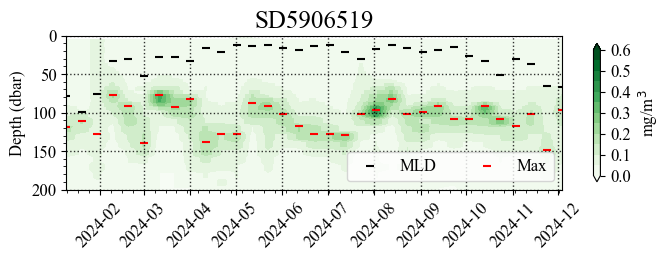

In [22]:
draw_var = chla_lerp_smqc_npq_dk.transpose(1, 0)
    
vmin = 0
vmax = 0.6
vint = 0.05
    
cm = plt.get_cmap('Greens') 
    
rcParams['figure.figsize'] = 8,2
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
cs = plt.contourf(time_list, depth_lerp, draw_var, 
                  cmap=cm, norm=Normalize(vmin=vmin, vmax=vmax),
                  levels=np.arange(vmin,vmax+vint,vint), extend='both')

dlon,ddep = 1,50
yticks=np.arange(0, 300,ddep)
ax1.set_title(f"{fnum}", fontsize=18)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax1.tick_params(axis='x', rotation=45)  # 日付ラベルを45度傾けて見やすくする
ax1.set_yticks(yticks)
ax1.axes.tick_params(labelsize=12)
ax1.set_ylabel("Depth (dbar)", size=12)
ax1.grid(linewidth=1, linestyle=':', color='k', alpha=0.8)
ax1.minorticks_on()
ax1.invert_yaxis()  # 深度を下向きにする
ax1.set_ylim(200, 0)
    
cbar = plt.colorbar(cs, shrink=0.9) 
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(np.linspace(vmin, vmax, num=7))
cbar.set_label('mg/m$^3$', size=12)

# MLDを赤線でプロット
ax1.scatter(time_list, MLD_array, c='k',marker='_', label='MLD')
ax1.scatter(time_list, chlmx[1], c='r',marker='_', label='Max')
# 凡例を追加
ax1.legend(loc='lower right', fontsize=12, ncol = 2)

#### Drawing float trajectory

In [25]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter

(17.0, 29.0)

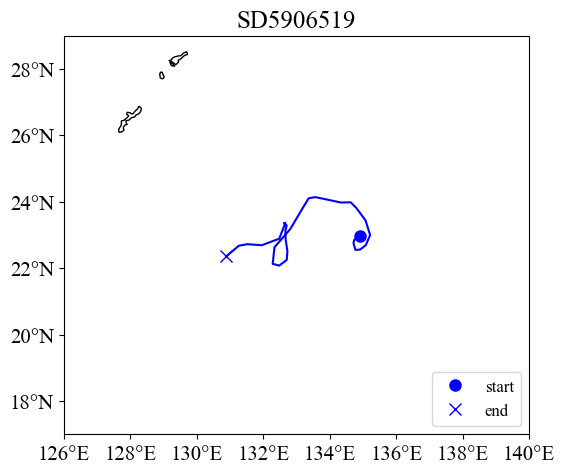

In [26]:
fig = plt.figure()
rcParams['figure.figsize'] = 6,6
c_lon = 180
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.plot(lon_array[:, 0],lat_array[:, 0], color = 'b', lw = '1.5', transform=ccrs.PlateCarree())

ax.plot(lon_array[0],lat_array[0], 'ob', markersize = '8', label = 'start', transform=ccrs.PlateCarree())
ax.plot(lon_array[32],lat_array[32], 'xb', markersize = '8', label = 'end', transform=ccrs.PlateCarree())
    

dlon,dlat=2,2
xticks=np.arange(60,360,dlon)
yticks=np.arange(-60,70.1,dlat)
ax.set_title(f"{fnum}", fontsize=18)
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())
ax.coastlines(lw=1.0,color='black',resolution='50m')

latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
ax.axes.tick_params(labelsize=15)
ax.legend(fontsize=12, loc = 'lower right')

wlim = int(np.round(lon_array.min()-5))
elim = int(np.round(lon_array.max()+5))
slim = int(np.round(lat_array.min()-5))
nlim = int(np.round(lat_array.max()+5))

ax.set_xlim(wlim, elim)
ax.set_ylim(slim, nlim)